# **Installs and Imports**

This cell includes all of the necessary pip installs when using google colab (this may not be needed if running on your personal device)

In [ ]:
!pip install tensorflow
!pip install keras

This cell includes all necessary imports to run this project

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.metrics import classification_report

This cell is to connect to google drive when running on google colab (my dataset was uploaded to my google drive)
- Skip this cell if you do not need to connect to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset Prep**

**Load Dataset**
- uses pandas to read the training data from the csv file
- you will need to change the root to the file for whereever you have stored the train.csv file
- changes column names to 'token' and 'tag'
- prints off first ten datapoints

In [ ]:
jnlpba_data = pd.read_csv("/content/drive/MyDrive/EE8204/train.csv", names=['Token', 'Tag'])
jnlpba_data.head(10)

,Token,Tag
0,-DOCSTART-,O
1,NaN,B-DNA
2,gene,I-DNA
3,expression,O
4,and,O
5,NF-kappa,B-protein
6,B,I-protein
7,activation,O
8,through,O
9,CD28,B-protein


**Getting dataset value counts**
- gets the total # of words (rows in 'token' colum) and total # of categories (unique rows in the 'tags'column) for later use


In [ ]:
words = list(set(jnlpba_data["Token"].values))
tags = list(set(jnlpba_data["Tag"].values))
num_words = len(words)
num_tags = jnlpba_data['Tag'].nunique()
print("Unique words in corpus:", jnlpba_data['Tag'].nunique())
print("Unique words in dataset:", len(words))

Unique words in corpus: 11
Unique words in dataset: 19224


**Seperate sentences**
- The dataset seperates sentences using a NaN token
- This cell adds a new column with the # of the sentence, and then assigns them based on where the NaN tokens have split up the tokens
- Then stores the tags and tokens into 2d arrays for later use in training

In [ ]:
# Fill NaN values with a placeholder
jnlpba_data['Token'] = jnlpba_data['Token'].fillna('Sentence_End')

# Create a new column for sentence IDs
jnlpba_data['Sentence_ID'] = (jnlpba_data['Token'] == 'Sentence_End').cumsum()

# Filter out the placeholder rows to clean your dataset
jnlpba_data = jnlpba_data[jnlpba_data['Token'] != 'Sentence_End']

In [ ]:
sentences = []
tag_sequences = []

for sentence_id in jnlpba_data['Sentence_ID'].unique():
    subset = jnlpba_data[jnlpba_data['Sentence_ID'] == sentence_id]
    words = list(subset['Token'])
    tags = list(subset['Tag'])
    sentences.append(words)
    tag_sequences.append(tags)

print("First two sentences:", sentences[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Padding and Tokenization**
- Tokenizing all of the inputs using Tensorflows built in tokenizer
- Padding inputs to the max length of 50

In [ ]:
max_len = 50

# Tokenization
word_tokenizer = Tokenizer(num_words=num_words, oov_token="UNK")
word_tokenizer.fit_on_texts(sentences)
X = word_tokenizer.texts_to_sequences(sentences)
X = pad_sequences(X, maxlen=max_len, padding='post')

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(tag_sequences)
Y = tag_tokenizer.texts_to_sequences(tag_sequences)
Y = pad_sequences(Y, maxlen=max_len, padding='post')

# Padding
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

# Convert tag indices to categorical labels
Y = [to_categorical(i, num_classes=num_tags + 1) for i in Y]  # +1 for padding token class

print("X shape:", X.shape)
print("Y shape:", np.array(Y).shape)


X shape: (16812, 50)
Y shape: (16812, 50, 12)


# **Model**

**Model Building**
- Simple input layer
- Embedding layer with input dimension of 19226, output dimension of 50
- Dropout layer to avoid overfitting
- Bidirectional LSTM layer with 100 units
- Output layer with softmax for classification

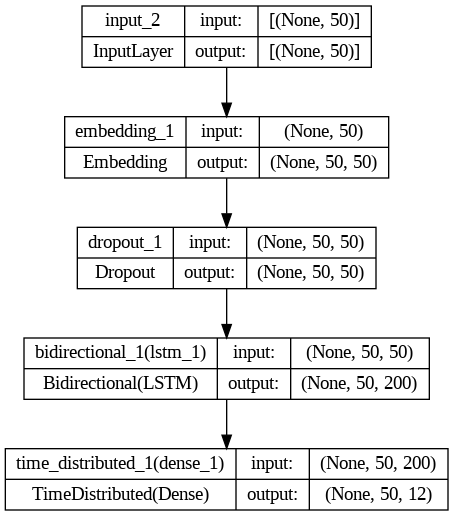

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# Define the model architecture
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words + 1, output_dim=50, input_length=max_len)(input_word)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags + 1, activation="softmax"))(model)

model = Model(inputs=input_word, outputs=out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Generate and save the plot of the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Optionally display the generated model plot
from IPython.display import Image
display(Image(filename='model_plot.png'))

**Train the model**
- Batch size of 32
- 5 training epochs

In [ ]:
history = model.fit(X, np.array(Y), batch_size=32, epochs=5, verbose=1)

Epoch 1/5
526/526 [==============================] - 104s 185ms/step - loss: 0.4406 - accuracy: 0.8807
Epoch 2/5
526/526 [==============================] - 99s 189ms/step - loss: 0.1498 - accuracy: 0.9503
Epoch 3/5
526/526 [==============================] - 97s 184ms/step - loss: 0.1021 - accuracy: 0.9656
Epoch 4/5
526/526 [==============================] - 97s 184ms/step - loss: 0.0827 - accuracy: 0.9719
Epoch 5/5
526/526 [==============================] - 98s 187ms/step - loss: 0.0711 - accuracy: 0.9759


# **Preparing the testing data**

**Load Testing Dataset**
- uses pandas to read the testing data from the csv file
- you will need to change the root to the file for whereever you have stored the train.csv file
- changes column names to 'token' and 'tag'
- prints off first ten datapoints

In [ ]:
# Load the testing data
test_data = pd.read_csv('/content/drive/MyDrive/EE8204/test.csv', names=['Token', 'Tag'])

print(test_data.head(10))

            Token          Tag
0      -DOCSTART-            O
1             NaN            O
2              of            O
3  glucocorticoid    B-protein
4       receptors    I-protein
5              in            O
6     lymphocytes  B-cell_type
7             and            O
8           their            O
9     sensitivity            O


**Seperate sentences**
- The dataset seperates sentences using a NaN token
- This cell adds a new column with the # of the sentence, and then assigns them based on where the NaN tokens have split up the tokens

In [ ]:
# Replace NaN values with a placeholder if necessary
test_data['Token'] = test_data['Token'].fillna('Sentence_End')

# Adding a new column for Sentence IDs to aggregate tokens/tags into sentences
test_data['Sentence_ID'] = (test_data['Token'] == 'Sentence_End').cumsum()
test_data = test_data[test_data['Token'] != 'Sentence_End']

# Group by Sentence_ID to reconstruct sentences
test_sentences = test_data.groupby('Sentence_ID')['Token'].apply(list).values
test_tags = test_data.groupby('Sentence_ID')['Tag'].apply(list).values

**Padding and Tokenization**
- Tokenizing all of the inputs using Tensorflows built in tokenizer
- Padding inputs to the max length of 50

In [ ]:
# Convert sentences to sequences
X_test = word_tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(X_test, maxlen=50, padding='post')  # Use the same max_len as in training

# Convert tag sequences
Y_test = tag_tokenizer.texts_to_sequences(test_tags)
Y_test = pad_sequences(Y_test, maxlen=50, padding='post')
Y_test = np.array([to_categorical(i, num_classes=num_tags+1) for i in Y_test])

# Proper padding
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')
Y_test_indices = np.argmax(Y_test, axis=-1)

Correctly shaped Y_test_indices: (3868, 50)


# **Testing**

**Producing Tesing Metrics**

In [ ]:
predictions = model.predict(X_test, verbose=1)

pred_indices = np.argmax(predictions, axis=-1)

idx2tag = tag_tokenizer.index_word
flat_pred_tags = [[idx2tag.get(idx, 'O') for idx in sentence] for sentence in pred_indices]

Y_test_indices = np.argmax(Y_test, axis=-1)

# Converting indices to tags
flat_true_tags = [[idx2tag.get(int(idx), 'O') for idx in sentence] for sentence in Y_test_indices]

# Flattening the list of tags for classification report
flat_true_tags = [tag for sublist in flat_true_tags for tag in sublist]
flat_pred_tags = [tag for sublist in flat_pred_tags for tag in sublist]

# Generate and print the classification report
print(classification_report(flat_true_tags, flat_pred_tags))

**Produce Accuracy & Loss Plots**

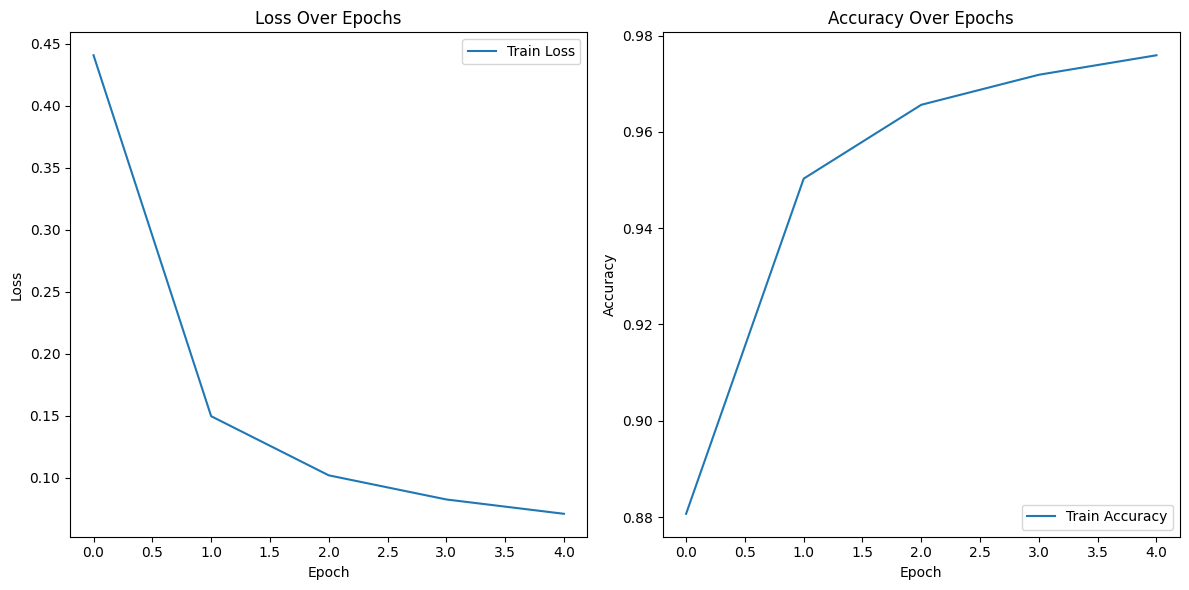

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_history(history)
